In [1]:
import pandas as pd
import numpy as np
import glob, os
from tqdm import tqdm
import _thread
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

In [2]:
df = pd.read_csv('../data/DE30_EUR.2018_2019.M1', index_col=None, header=None)
df.columns = ['timestamp', 'Complete', 'Open', 'High', 'Low', 'Close', 'Volume']
df = df[['timestamp','Open','High','Low', 'Close', 'Volume']]
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index(['timestamp'])
df.head()

,Open,High,Low,Close,Volume
timestamp,,,,,
2018-01-02 07:00:00,12921.6,12923.6,12917.3,12922.8,101
2018-01-02 07:01:00,12923.2,12933.6,12923.0,12931.6,106
2018-01-02 07:02:00,12931.0,12933.0,12917.3,12917.6,121
2018-01-02 07:03:00,12917.1,12922.2,12916.0,12920.3,106
2018-01-02 07:04:00,12920.6,12925.3,12920.6,12925.3,52


In [3]:
#set actions

minutes_to_look_forward = 20
tp = 5

price = df[['Close', 'Low', 'High']].to_numpy()
buy = []
sell = []
wait = []

for i in tqdm(range(len(df))):
    current_buy = 0
    current_sell = 0
    current_wait = 0
    for next_price in price[i+1:i+minutes_to_look_forward]:
        if current_buy == 0 and current_sell == 0:
            if next_price[2] - price[i][0] > tp:
                current_buy = 1
            if price[i][0] - next_price[1] > tp:
                current_sell = 1
            if current_buy == 1 and current_sell == 1:
                current_buy = 0
                current_sell = 0
    if current_buy == 0 and current_sell == 0:
        current_wait = 1
    buy.append(current_buy)
    sell.append(current_sell)
    wait.append(current_wait)

df['buy'] = buy
df['sell'] = sell
df['wait'] = wait

100%|██████████| 409118/409118 [00:06<00:00, 60722.28it/s]


In [4]:
(df[df['buy'] == 1]['buy'].count() / len(df)) * 100

45.70099580072253

In [5]:
(df[df['sell'] == 1]['sell'].count() / len(df)) * 100

45.11705669269013

In [6]:
(df[df['wait'] == 1]['wait'].count() / len(df)) * 100

9.181947506587342

In [7]:
df = df.drop(['wait'], axis=1)

In [8]:
df = df[(df['buy'] == 1) | (df['sell'] == 1)]

In [9]:
def plot_actions_in_range(start_index, end_index):
    df_def = df.reset_index()[start_index:end_index]
    df_sell = df_def[df_def['sell'] == 1]
    df_buy = df_def[df_def['buy'] == 1]
    sns.lineplot(y=df_def['Close'], x=df_def['timestamp'])
    sns.scatterplot(y=df_buy['Close'], x=df_def['timestamp'], color='green')
    sns.scatterplot(y=df_sell['Close'], x=df_def['timestamp'], color='red')

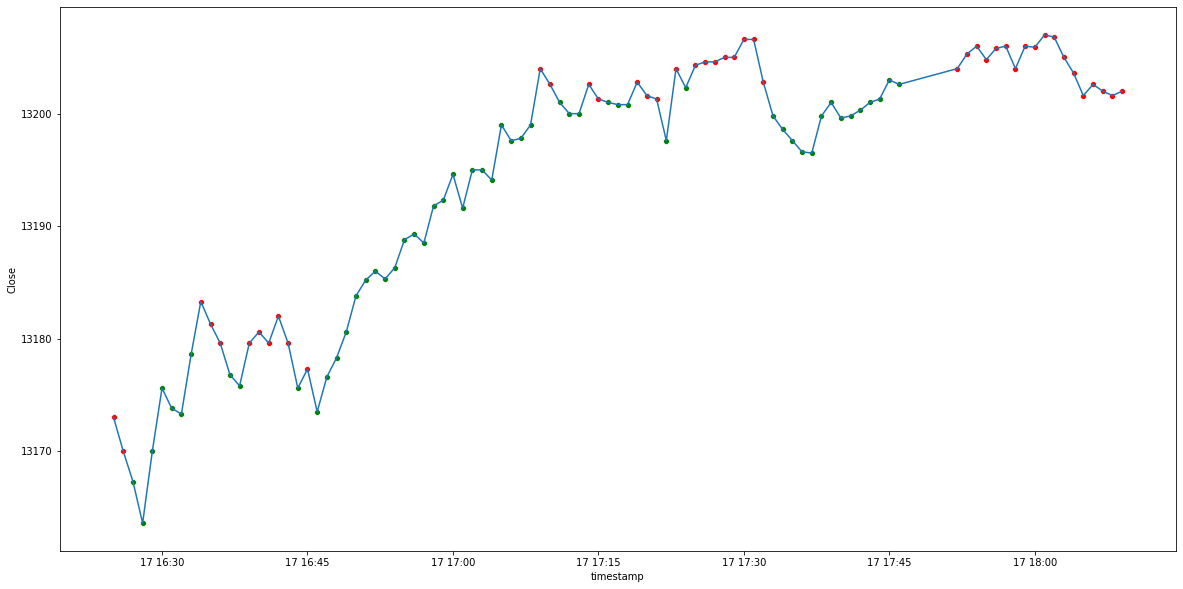

In [10]:
fig, ax = plt.subplots(figsize=(20,10))
plot_actions_in_range(9000,9100)

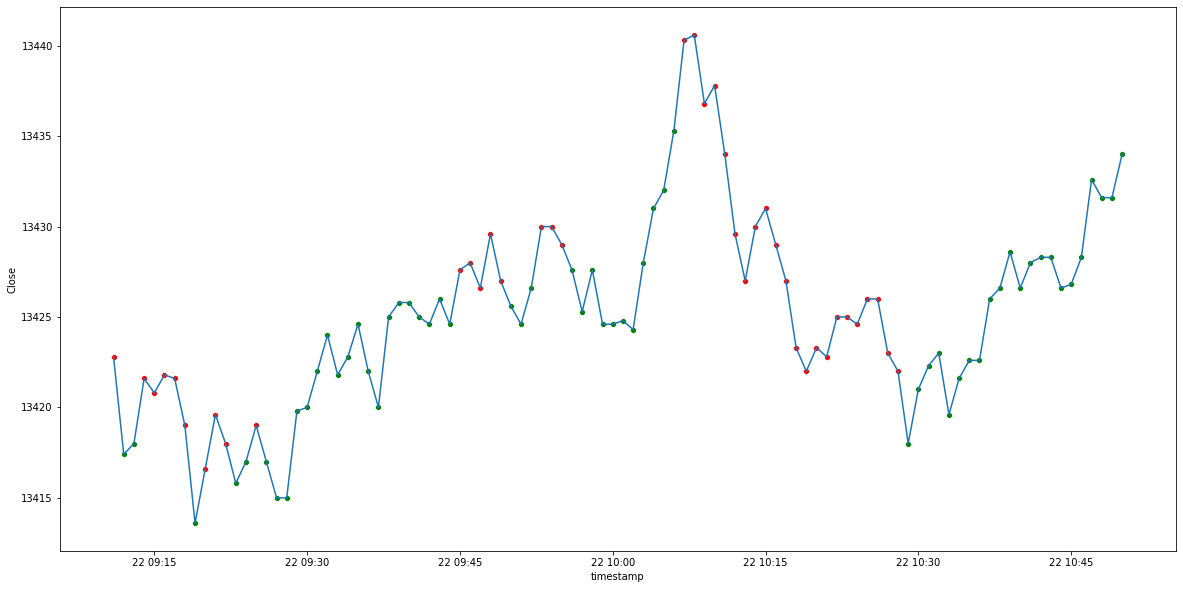

In [11]:
fig, ax = plt.subplots(figsize=(20,10))
plot_actions_in_range(11000,11100)

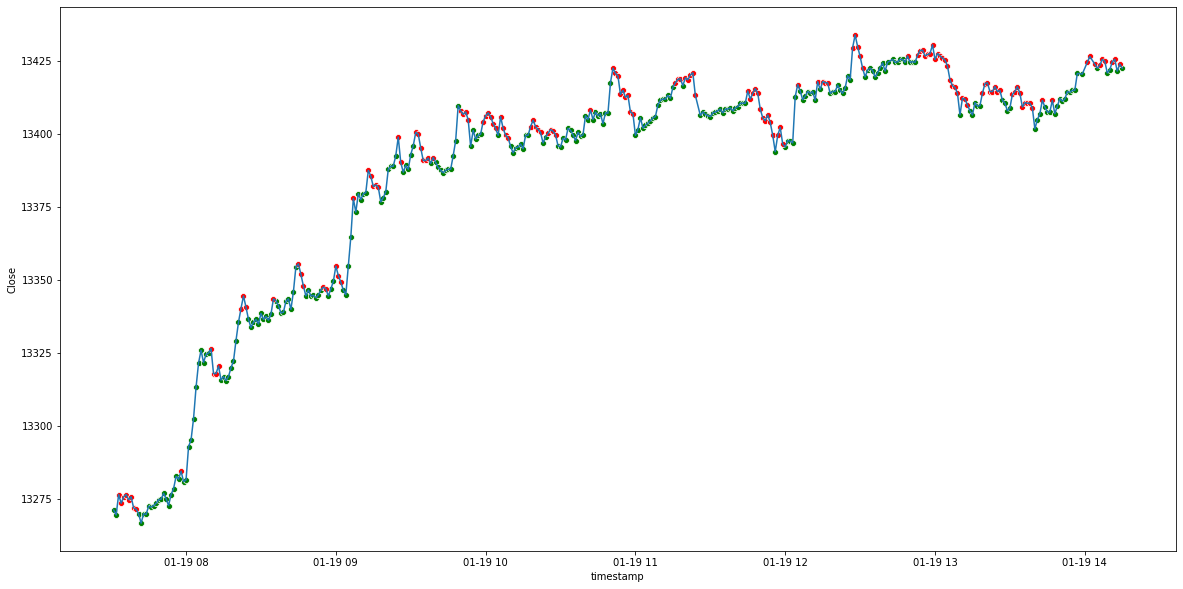

In [12]:
fig, ax = plt.subplots(figsize=(20,10))
plot_actions_in_range(10100,10500)

In [13]:
df_train = df[:'2019-05-01']
df_test = df['2019-05-01':]

In [14]:
from sklearn import preprocessing

def normalize(data):
    df_norm = data.copy()
    min_max_scaler = preprocessing.MinMaxScaler()
    df_norm = min_max_scaler.fit_transform(df_norm)
    return df_norm

# Train with only the price

In [15]:
X_train = normalize(df_train.drop(['buy', 'sell'], axis=1))
Y_train = df_train['buy'].to_numpy()

X_test = normalize(df_test.drop(['buy', 'sell'], axis=1))
Y_test = df_test['buy'].to_numpy()

print("X train shape:", X_train.shape)
print("Y train shape:", Y_train.shape)
print("X test shape:", X_test.shape)
print("Y test shape:", Y_test.shape)

X train shape: (286246, 5)
Y train shape: (286246,)
X test shape: (85307, 5)
Y test shape: (85307,)


In [16]:
X_train

array([[0.79534631, 0.79523091, 0.79471037, 0.79583961, 0.04606172],
       [0.79582856, 0.79824932, 0.79642739, 0.79849261, 0.04836481],
       [0.79817952, 0.79806822, 0.79471037, 0.79427193, 0.05527407],
       ...,
       [0.62957381, 0.62873529, 0.62918336, 0.62888152, 0.02441271],
       [0.62888058, 0.62843344, 0.62918336, 0.62888152, 0.0294795 ],
       [0.62860932, 0.62831271, 0.62924361, 0.62867049, 0.00690926]])

In [76]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(verbose=1, n_estimators=10, n_jobs=10)
rf.fit(X_train, Y_train)
print("Train accuracy:", rf.score(X_train, Y_train))
print("Test accuracy:", rf.score(X_test, Y_test))

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    1.2s remaining:    4.9s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


Train accuracy: 0.9787630220160282


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy: 0.49675876540026026


In [77]:
rf = RandomForestClassifier(verbose=1, n_estimators=100, n_jobs=10)
rf.fit(X_train, Y_train)
print("Train accuracy:", rf.score(X_train, Y_train))
print("Test accuracy:", rf.score(X_test, Y_test))

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.6s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   14.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.8s finished


Train accuracy: 0.999510910196125


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.2s finished


Test accuracy: 0.49582097600431385


# Train with additionnal features

In [17]:
from talib.abstract import *

df['rsi'] = RSI(df['Close'], timeperiod=14)
df['bb_upperband'], df['bb_middleband'], df['bb_lowerband'] = BBANDS(df['Close'], timeperiod=20, nbdevup=2.0, nbdevdn=2.0, matype=0)
df = df.dropna()

In [18]:
df_train = df[:'2019-05-01']
df_test = df['2019-05-01':]

In [19]:
X_train = normalize(df_train.drop(['buy', 'sell'], axis=1))
Y_train = df_train['buy'].to_numpy()

X_test = normalize(df_test.drop(['buy', 'sell'], axis=1))
Y_test = df_test['buy'].to_numpy()

print("X train shape:", X_train.shape)
print("Y train shape:", Y_train.shape)
print("X test shape:", X_test.shape)
print("Y test shape:", Y_test.shape)

X train shape: (286227, 9)
Y train shape: (286227,)
X test shape: (85307, 9)
Y test shape: (85307,)


In [84]:
rf = RandomForestClassifier(verbose=1, n_estimators=10, n_jobs=-1, max_leaf_nodes=100)
rf.fit(X_train, Y_train)
print("Train accuracy:", rf.score(X_train, Y_train))
print("Test accuracy:", rf.score(X_test, Y_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


Train accuracy: 0.5520723062464408


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy: 0.4961960917626924


# Train with MORE features

In [32]:
df['CDLSPINNINGTOP'] = CDLSPINNINGTOP(df['Open'], df['High'], df['Low'], df['Close'])
df['CDLDOJI'] = CDLSPINNINGTOP(df['Open'], df['High'], df['Low'], df['Close'])
df['CDLMARUBOZU'] = CDLMARUBOZU(df['Open'], df['High'], df['Low'], df['Close'])
df['CDLHAMMER'] = CDLHAMMER(df['Open'], df['High'], df['Low'], df['Close'])
df['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(df['Open'], df['High'], df['Low'], df['Close'])
df['CDLHANGINGMAN'] = CDLHANGINGMAN(df['Open'], df['High'], df['Low'], df['Close'])
df['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(df['Open'], df['High'], df['Low'], df['Close'])
df['CDLENGULFING'] = CDLENGULFING(df['Open'], df['High'], df['Low'], df['Close'])
df['CDLMORNINGSTAR'] = CDLMORNINGSTAR(df['Open'], df['High'], df['Low'], df['Close'])
df['CDLEVENINGSTAR'] = CDLEVENINGSTAR(df['Open'], df['High'], df['Low'], df['Close'])
df['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(df['Open'], df['High'], df['Low'], df['Close'])
df['CDL3BLACKCROWS'] = CDL3BLACKCROWS(df['Open'], df['High'], df['Low'], df['Close'])
df['CDL3INSIDE'] = CDL3INSIDE(df['Open'], df['High'], df['Low'], df['Close'])
df['EMA20'] = EMA(df['Close'], timeperiod=20)
df['EMA80'] = EMA(df['Close'], timeperiod=80)
df['EMA200'] = EMA(df['Close'], timeperiod=200)
df['MOM'] = MOM(df['Close'], timeperiod=10)
df = df.dropna()

In [33]:
df_train = df[:'2019-05-01']
df_test = df['2019-05-01':]

In [34]:
X_train = normalize(df_train.drop(['buy', 'sell'], axis=1))
Y_train = df_train['buy'].to_numpy()

X_test = normalize(df_test.drop(['buy', 'sell'], axis=1))
Y_test = df_test['buy'].to_numpy()

print("X train shape:", X_train.shape)
print("Y train shape:", Y_train.shape)
print("X test shape:", X_test.shape)
print("Y test shape:", Y_test.shape)

X train shape: (286028, 26)
Y train shape: (286028,)
X test shape: (85307, 26)
Y test shape: (85307,)


In [35]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(verbose=1, n_estimators=1000, n_jobs=-1, max_leaf_nodes=50)
rf.fit(X_train, Y_train)
print("Train accuracy:", rf.score(X_train, Y_train))
print("Test accuracy:", rf.score(X_test, Y_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   43.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    2.5s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    3.3s finished


Train accuracy: 0.5506943376172962


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.8s finished


Test accuracy: 0.5061483817271736
